In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import json

with open('data_full.json') as file:
    data = json.loads(file.read())
    
#load out of scope intent data
val_oos = np.array(data['oos_val'])
train_oos = np.array(data['oos_train'])
test_oos = np.array(data['oos_test'])

#load other intetn data
val_others = np.array(data['val'])
train_others = np.array(data['train'])
test_others = np.array(data['test'])

#merging out of scope and other intent data
val = np.concatenate([val_oos,val_others])
train = np.concatenate([train_oos, train_others])
test = np.concatenate([test_oos,test_others])

data =np.concatenate([train,test,val])
data = data.T

text = data[0]
labels = data[1]

In [3]:
from sklearn.model_selection import train_test_split

train_txt,test_txt,train_label,test_labels = train_test_split(text,labels,test_size = 0.3)

Tokenizing

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_num_words = 40000
classes = np.unique(labels)
tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(train_txt)
word_index = tokenizer.word_index


In [7]:
ls =[]
for c in train_txt:
    ls.append(len(c.split()))
maxLen = int(np.percentile(ls,98))

train_sequences = tokenizer.texts_to_sequences(train_txt)
train_sequences = pad_sequences(train_sequences, maxlen=maxLen,
                               padding='post')

test_sequences = tokenizer.texts_to_sequences(test_txt)
test_sequences = pad_sequences(test_sequences, maxlen =maxLen,
                              padding='post')

In [8]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(classes)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded),1)
onehot_encoder.fit(integer_encoded)

train_label_encoded = label_encoder.transform(train_label)
train_label_encoded = train_label_encoded.reshape(len(train_label_encoded),1)
train_label = onehot_encoder.transform(train_label_encoded)

test_labels_encoded = label_encoder.transform(test_labels)
test_labels_encoded = test_labels_encoded.reshape(len(test_labels_encoded),1)
test_labels = onehot_encoder.transform(test_labels_encoded)

/opt/homebrew/Caskroom/miniforge/base/envs/finenv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
embeddings_index={}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:],dtype='float32')
        embeddings_index[word] = coefs

In [10]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()

num_words = min(max_num_words, len(word_index))+1

embedding_dim = len(embeddings_index['the'])

embedding_matrix = np.random.normal(emb_mean,emb_std,(num_words,
                                                     embedding_dim))
for word, i in word_index.items():
    if i >=max_num_words:
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

/opt/homebrew/Caskroom/miniforge/base/envs/finenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout,LSTM, Activation, Bidirectional, Embedding

model = Sequential()

model.add(Embedding(num_words, 100,
                  trainable=False, input_length=train_sequences.shape[1],
                  weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(256, return_sequences=True,
                            recurrent_dropout=0.1, dropout=0.1),'concat'))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=False, recurrent_dropout=0.1,
         dropout=0.1))
model.add(Dropout(0.3))
model.add(Dense(50,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(classes.shape[0], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam',
             metrics=['acc'])

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 16, 100)           635700    
                                                                 
 bidirectional_1 (Bidirectio  (None, 16, 512)          731136    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 16, 512)           0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               787456    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                12850     
                                                      

In [17]:
history = model.fit(train_sequences, train_label, epochs=20,
                   batch_size = 64, shuffle=True,
                   validation_data=[test_sequences, test_labels])

Epoch 1/20


2023-03-04 01:52:26.480084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


260/260 [==============================] - ETA: 0s - loss: 4.7827 - acc: 0.0412

2023-03-04 02:02:22.429056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


260/260 [==============================] - 616s 2s/step - loss: 4.7827 - acc: 0.0412 - val_loss: 4.0773 - val_acc: 0.0768
Epoch 2/20
260/260 [==============================] - 667s 3s/step - loss: 3.6233 - acc: 0.1141 - val_loss: 2.7831 - val_acc: 0.2678
Epoch 3/20
260/260 [==============================] - 590s 2s/step - loss: 2.5292 - acc: 0.2983 - val_loss: 1.7841 - val_acc: 0.5224
Epoch 4/20
260/260 [==============================] - 521s 2s/step - loss: 1.7886 - acc: 0.4898 - val_loss: 1.3064 - val_acc: 0.6346
Epoch 5/20
260/260 [==============================] - 581s 2s/step - loss: 1.3274 - acc: 0.6248 - val_loss: 0.9617 - val_acc: 0.7378
Epoch 6/20
260/260 [==============================] - 575s 2s/step - loss: 1.0059 - acc: 0.7168 - val_loss: 0.8111 - val_acc: 0.7752
Epoch 7/20
260/260 [==============================] - 586s 2s/step - loss: 0.8239 - acc: 0.7662 - val_loss: 0.7144 - val_acc: 0.8059
Epoch 8/20
260/260 [==============================] - 488s 2s/step - loss: 0.672

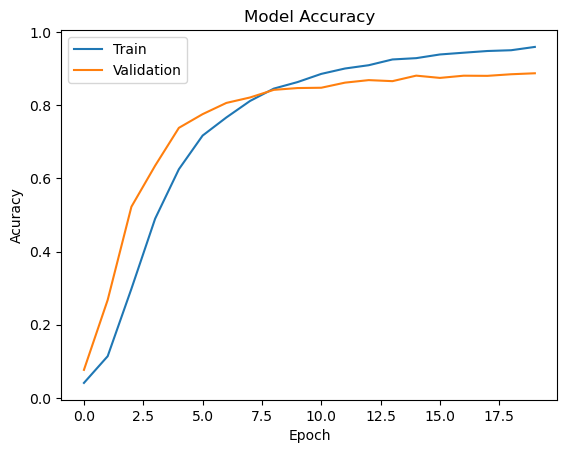

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Acuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc = 'upper left')
plt.show()

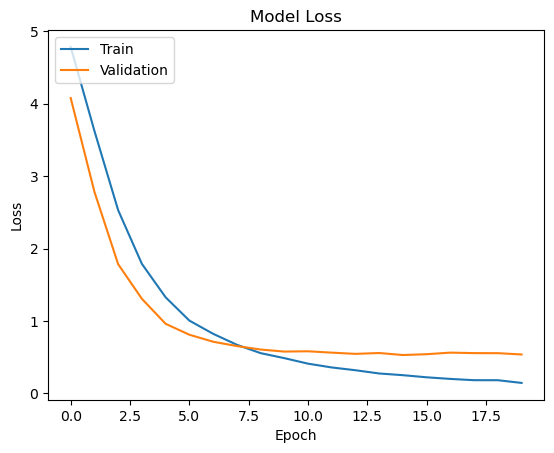

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [20]:
import pickle
import json

model.save('models/intents_tff.h5')

with open('utils/classes_tff.pkl','wb') as file:
   pickle.dump(classes,file)

with open('utils/tokenizer_tff.pkl','wb') as file:
   pickle.dump(tokenizer,file)

with open('utils/label_encoder_tff.pkl','wb') as file:
   pickle.dump(label_encoder,file)

In [3]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences
class IntentClassifier:
    def __init__(self,classes,model,tokenizer,label_encoder):
        self.classes = classes
        self.classifier = model
        self.tokenizer = tokenizer
        self.label_encoder = label_encoder

    def get_intent(self,text):
        self.text = [text]
        self.test_keras = self.tokenizer.texts_to_sequences(self.text)
        self.test_keras_sequence = pad_sequences(self.test_keras, maxlen=16, padding='post')
        self.pred = self.classifier.predict(self.test_keras_sequence)
        return self.label_encoder.inverse_transform(np.argmax(self.pred,1))[0]

In [1]:
import pickle

from tensorflow.keras.models import load_model
model = load_model('models/intents_tff.h5')

with open('utils/classes_tff.pkl','rb') as file:
  classes = pickle.load(file)

with open('utils/tokenizer_tff.pkl','rb') as file:
  tokenizer = pickle.load(file)

with open('utils/label_encoder_tff.pkl','rb') as file:
  label_encoder = pickle.load(file)

Metal device set to: Apple M1 Pro


2023-03-06 10:29:32.424975: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-06 10:29:32.425265: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
nlu = IntentClassifier(classes,model,tokenizer,label_encoder)
print(nlu.get_intent("what temperature is it in Delhi "))
# Should Print 'weather'

2023-03-06 10:29:59.440075: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-06 10:29:59.586191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


weather


In [5]:
nlu = IntentClassifier(classes,model,tokenizer,label_encoder)
print(nlu.get_intent("I love eating pasta"))

recipe


In [17]:
nlu = IntentClassifier(classes,model,tokenizer,label_encoder)
print(nlu.get_intent("Tell me a good restaurant to eat pasta"))

restaurant_suggestion


In [18]:
nlu = IntentClassifier(classes,model,tokenizer,label_encoder)
print(nlu.get_intent("Change me booking to Friday "))

confirm_reservation


In [19]:
nlu = IntentClassifier(classes,model,tokenizer,label_encoder)
print(nlu.get_intent("Say hi in spanish"))

translate


In [13]:
nlu = IntentClassifier(classes,model,tokenizer,label_encoder)
print(nlu.get_intent("Change the order number to 6"))
#out of scope

oos


In [16]:
nlu = IntentClassifier(classes,model,tokenizer,label_encoder)
print(nlu.get_intent("What is your nationality?"))

where_are_you_from


In [15]:
nlu = IntentClassifier(classes,model,tokenizer,label_encoder)
print(nlu.get_intent("What is your name?"))

what_is_your_name
